<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4_Nuclear/blob/main/Lab4_Poisson_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import poisson
from scipy.stats import chi2

In [16]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_14/1_Background.tsv'
data = np.genfromtxt(URL, delimiter='\t', skip_header=11, usecols=2)
#QTY = 40
#s = np.random.choice(data, QTY)
s = data
m = len(s)
n = s.mean()
freqs = s / m
#print(s.mean(), s.std())
I_background = s.mean() / 10
print(f'Bacground intensity I {I_background:.2f} counts/s')

Bacground intensity I 0.21 counts/s


In [3]:
BINS = 100
DOF = BINS - 2
def expected(x, m):
  return poisson(n).pmf(x) * m
def observed(i):
  ans = 0
  for counts in s:
    if i == counts:
      ans += 1
  return ans

Ok = np.array([observed(i) for i in range(BINS)])
Ek = np.array([expected(i, m) for i in range(BINS)])

chisquare0 = np.sum((Ok - Ek)**2 / Ek) / DOF
#for i in range(BINS):
#  print(f'{i}, {Ok[i]}, {Ek[i]:.1f}, {(Ok[i] - Ek[i])**2 / Ek[i]:.1f}')

#chi2.pdf(chisquare0 * DOF, DOF)
chisquare0

0.07638896849595767

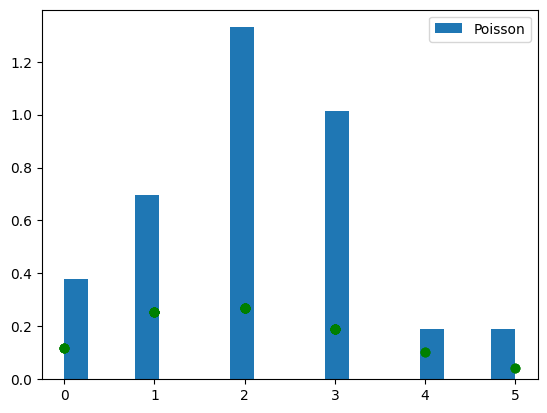

In [4]:
count, bins, ignored = plt.hist(s, 19,  density=True, label='Poisson')
#plt.xticks(range(0, int(s.max())+1))
plt.legend()
plt.scatter(s, poisson.pmf(s, n), color='green')
plt.show()

In [5]:
k3 = (s - s.mean())**3
K3 = k3.sum()/(m-1)
s.mean(), s.std(), K3

(2.1333333333333333, 1.2174654911833116, 0.44549905838041454)

In [6]:
n, err = s.mean(), s.std()/np.sqrt(m)
# relative error in intensity
n, err

(2.1333333333333333, 0.15717411906450662)

In [7]:
errK3 = np.sqrt(k3.var() / (m - 1))
K3, errK3

(0.44549905838041454, 0.8192547233533447)

# Inverse square

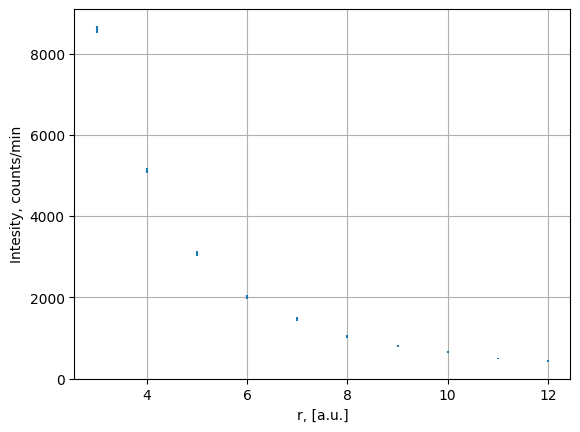

In [8]:
measurements = '''
1 429
2 491
3 646
4 805
5 1033
6 1465
7 2000
8 3077
9 5121
10 8587
'''
data = np.genfromtxt(measurements.splitlines())
x, I = data.T
h = 13
r = h - x
Ierr = np.sqrt(I)

plt.errorbar(r, I, yerr=Ierr, linestyle='')
plt.xlabel('r, [a.u.]')
plt.ylabel('Intesity, counts/min')
plt.grid()


# Attenuation $I = I_0 e^{-\mu d}$

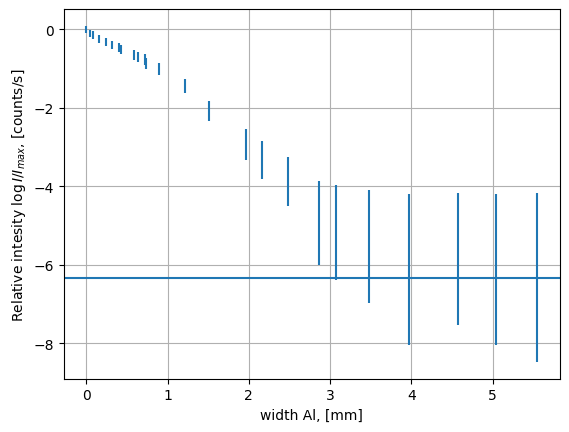

In [34]:
measurements = '''
2480 3070  13
2480 0     152
400 240    3592
400 320 3381
0  0   7280
3070 0 41
2160 0 259
1970 0 386
1510 0 913
1210 0 1716
900 0 2666
740 0 3041
590 0 3796
430 0 4362
400 0 4635
320 0 4918
240 0 5268
160 0 5675
80 0 6345
40 0 6593
3070 900 16
3070 1970 16
1970 900 52
1970 1510 29
3070 1510 21
'''
data = np.genfromtxt(measurements.splitlines())
d1, d2, I = data.T
d = d1 + d2
I = I / 60 # counst/min -> counts/s
I_rel = I / np.max(I) # relative

plt.errorbar(d*1e-3, np.log(I_rel), yerr=1/np.sqrt(I), linestyle='')
plt.xlabel('width Al, [mm]')
plt.ylabel('Relative intesity $\log I/I_{max}$, [counts/s]')
plt.axhline(np.log(I_background/np.max(I)))
plt.grid()
